<h2>
Exploratory Statistics of Pairs Trading
</h2>
<p>
The Jupyter notebook explores pairs trading strategies.
This document is available on the GitHub repository https://github.com/IanLKaplan/pairs_trading
</p>
<blockquote>
<p>
Pairs trading is an approach that takes advantage of the
mispricing between two (or more) co-moving assets, by
taking a long position in one (many) and shorting the
other(s), betting that the relationship will hold and that
prices will converge back to an equilibrium level.
</p>
<p>
<i>Definitive Guide to Pairs Trading</i> availabel from <a href="https://hudsonthames.org/">Hudson and Thames</a>
</p>
</blockquote>
<p>
Pairs trading is sometimes referred to as a statistical arbitrage trading strategy.
</p>
<blockquote>
<p>
Statistical arbitrage and pairs trading tries to solve this problem using price relativity. If two assets share the same
characteristics and risk exposures, then we can assume that their behavior would be similar as well. This has
the benefit of not having to estimate the intrinsic value of an asset but rather just if it is under or overvalued
relative to a peer(s). We only have to focus on the relationship between the two, and if the spread happens
to widen, it could be that one of the securities is overpriced, the other is underpriced, or the mispricing is a
combination of both.
</p>
<p>
<i>Definitive Guide to Pairs Trading</i> available from <a href="https://hudsonthames.org/">Hudson and Thames</a>
</p>
</blockquote>
<p>
Pairs trading algorithms have been reported to yield portfolios with Sharpe ratios in excess of 1.0 and returns of 10% or
higher. Pairs trading takes both long and short positions, so the portfolio tends to be market neutral. A pairs trading portfolio
can have drawdowns, but the drawdowns should be less than a benchmark like the S&P 500 because of the market neutral nature of the
portfolio. The lower, market neutral, structure of a pairs trading portfolio means that the portfolio will have a lower return
than a comparable benchmark like the S&P 500.
</p>
<p>
Markets tend toward efficiency and many quantitative approaches fade over time as they are adopted by hedge funds. Pairs trading
goes back to the mid-1980s. Surprisingly, pairs trading still seems to be profitable. One reason for this could be that there are a vast
number of possible pairs and the pairs portfolio is a faction of the pairs universe. This could
leave unexploited pairs in the market. Pairs trading may also be difficult to scale to a level that would be attractive to institutional
traders, like hedge funds, so the strategy has not been arbitraged out of the market.
</p>
<p>
Mathematical finance often uses models that are based on normal distributions, constant means and standard deviations. Actual market
data is often not normally distributed and changes constantly. The statistics used to select stocks for pairs trading assume
that the pair distribution has a constant mean and standard deviation (e.g., the pairs spread is a stationary time series). As this notebook
shows, this assumption is statistically valid about forty percent of the time.
</p>
<p>
The statistics that predict a successful pair will not be accurate in all time periods. For the strategy to be successful, the prediction
must be right more often than not. To minimize the risk in any particular trade, this suggests that trading a larger portfolio will
be more successful than trading a small portfolio.
</p>
<h3>
Overview
</h3>
<p>
The primary references used for this notebook are the books <i>Pairs Trading</i> by Ganapathy Vidyamurthy and <i>Algorithmic
Trading</i> by Ernest P. Chan.
</p>
<p>
The pairs trading strategy attempts to find a pair of stocks where the weighted spread between the stock close prices is
mean reverting.
</p>
<p>
Implementing the pairs trading strategy involves two logical steps:
</p>
<ol>
<li>
<p>
Pairs selection: Identify a pair of stocks that are likely to have mean reverting behavior using a lookback period.
</p>
</li>
<li>
<p>
Trading the stocks using the long/short strategy over the trading period. This involves building a trading signal
from the weighted spread formed from the close prices of the stock pair. When the trading signal is above or below
the mean by some threshold value, a long and short position are taken in the two stocks.
</p>
</li>
</ol>
<h2>
Pairs Selection
</h2>
<h3>
S&P 500 Industry Sectors
</h3>
<p>
In this notebook, pairs are selected from the S&P 500 stock universe. These stocks have a high trading volume, with a small
bid-ask spread. S&P 500 stocks are also easier to short, with lower borrowing fees and a lower chance of a short position being called
back.
</p>
<p>
In pairs selection we are trying to find pairs that are cointegrated, where the price spread has mean reverting behavior. Just as there
can be spurious correlation there can be spurious cointegration, so the stock pair should
have some logical connection. In the book <i>Pairs Trading</i> (Vidyamurthy) the author discusses using factor models to select pairs with
similar factor characteristics.
</p>
<p>
Factor models are often built using company fundamental factors like earnings, corporate debt and cash flow. These factors
tend to be generic. Many companies in completely different industry sectors may have similar fundamental factors.  When selecting pairs
we would like to select stocks that are affected by similar market forces. For example, energy sector stocks tend to be
affected by the same economic and market forces. Factors affecting companies outside the energy sector can be much more complicated.
In many cases the company factors that affect S&P 500 companies are broad economic factors that are not obviously useful in choosing pairs
for mean reversion trading.
</p>
<p>
In lieu of specific factors, the S&P 500 industry sector is used as the set from which pairs are drawn.
Although not perfect, the industry sector will tend to select stocks with similar behavior, while reducing the universe of
stocks from which pairs are selected.
</p>
<p>
Reducing the universe of stock pairs is important because, even with modern computing power, it would be difficult
to test all possible stock pairs in the S&P 500, since the number of pairs grows exponentially with N, the number of stocks.
</p>

\$ number \space of \space pairs = \frac{N^2 - N}{2} $

<p>
The S&P 500 component stocks (in 2022) and their related industries have been downloaded from barchart.com.  The files are included in this
GitHub repository.
</p>
<p>
The S&P 500 industry sectors are:
</p>
<ol>
<li>
Consumer discretionary
</li>
<li>
Consumer staples
</li>
<li>
Energy
</li>
<li>
Financials
</li>
<li>
Health care
</li>
<li>
Industrials
</li>
<li>
Infotech
</li>
<li>
Materials
</li>
<li>
Real estate
</li>
<li>
Communication services
</li>
<li>
Utilities
</li>
</ol>
<p>
The stocks from the Barchart list include stocks for the same company, with different classes (e.g., class A, class B or class C stocks).
The list of stocks is filtered to remove all but the lowest stock class (e.g., if there is a class B stock, the class A stock is removed
from the list).
</p>
<h3>
Stock Market Close Data
</h3>
<p>
The data used to model pairs trading in this notebook uses close price data for all of the S&P 500 stocks from the start date to yesterday
(e.g., one day in the past). In other models (see Stock Market Cash Trigger and ETF Rotation) the close price data was downloaded the first time the
notebook was run and stored in temporary files.  The first notebook run incurred the initial overhead of downloading
the data, but subsequent runs could read the data from local temporary files.
</p>
<p>
For the S&P 500 stock universe, downloading all of the close price data the first time the notebook is run would have an unacceptable
overhead. To avoid this, the data is downloaded once and stored in local files. When the notebook is run at later times, only the
data between the end of the last date in the file and the current end date will be downloaded.
</p>
<p>
There are stocks in the S&P 500 list that were listed on the stock exchange later than the start date.  These
stocks are filtered out, so the final stock set does not include all of the S&P 500 stocks.
</p>
<p>
Filtering stocks in this way can create a survivorship bias. This should not be a problem for back testing pairs trading
algorithms through the historical time period. The purpose of this backtest is to understand the pairs trading behavior.
The results do not depend on the stock universe, only on the pairs selected.
</p>


In [1]:

#
# To generate a python file from the notebook use jupytext:
# pip install jupytext --upgrade
# jupytext --to py pairs_trading.ipynb
#

import os
from datetime import datetime
# pathos is used as a more robust multiprocessing library
# pip install pathos
from pathos.multiprocessing import Pool
from typing import List, Tuple, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from numpy import log
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from tabulate import tabulate

from coint_analysis.coint_analysis_result import CointAnalysisResult, CointInfo
from coint_data_io.coint_matrix_io import CointMatrixIO
#
# Local libraries
#
from plot_ts.plot_time_series import plot_ts, plot_two_ts
from read_market_data.MarketData import MarketData, read_s_and_p_stock_info, extract_sectors

# Apply the default theme
sns.set_theme()

from s_and_p_filter import s_and_p_directory, s_and_p_stock_file
s_and_p_file = s_and_p_directory + os.path.sep + s_and_p_stock_file

start_date_str = '2007-01-03'
start_date: datetime = datetime.fromisoformat(start_date_str)

trading_days = 252


def calc_pair_counts(sector_info: dict) -> pd.DataFrame:
    """
    Return a DataFrame
    :param sector_info: a dictionary where the key is the sector name and the
                        value is a list of stock symbols for that sector
    :return: a DataFrame where the index is the sector names and the columns are "num stocks" and "num pairs"
             "num stocks" is the number of stocks in the sector. "num pairs" is the number of unique pairs
             that can be formed from the set of sector stocks.  The last row is the sum of the columns.
    """
    column_label = ['num stocks', 'num pairs']
    sectors = list(sector_info.keys())
    counts_l: list = list()
    n_l: list = list()
    for sector in sectors:
        n = len(sector_info[sector])
        n_l.append(n)
        count = ((n ** 2.0) - n) / 2.0
        counts_l.append(count)
    num_stocks = sum(n_l)
    info_df = pd.DataFrame(n_l)
    info_df = pd.concat([info_df, pd.DataFrame(counts_l)], axis=1)
    info_df.columns = column_label
    sum_pairs = sum(counts_l)
    num_stocks_df = pd.DataFrame([num_stocks])
    sum_df = pd.DataFrame([sum_pairs])
    row_df = pd.concat([num_stocks_df, sum_df], axis=1)
    row_df.columns = column_label
    info_df = pd.concat([info_df, row_df], axis=0)
    sectors.append('Sum')
    info_df.index = sectors
    return info_df


# stock_info_df: a DataFrame with columns Symbol, Name, Sector
stock_info_df = read_s_and_p_stock_info(s_and_p_file)
stock_l: list = list(set(stock_info_df['Symbol']))
stock_l.sort()
market_data = MarketData(start_date=start_date)

# Get close prices for the S&P 500 list
close_prices_df = market_data.get_close_data(stock_l)
final_stock_list = list(close_prices_df.columns)
mask = stock_info_df['Symbol'].isin(final_stock_list)
# Some stocks were listed on the stock exchange later than start_date. In this case the stock will not
# be returned by MarketData.get_close_data(). final_stock_info has the Symbol, Name, Sector for the
# set of stocks that it was possible to obtain close prices for the date range.
final_stock_info_df = stock_info_df[mask]

sectors = extract_sectors(final_stock_info_df)
pairs_info_df = calc_pair_counts(sectors)



1 Failed download:
- CTXS: No data found, symbol may be delisted

1 Failed download:
- NLSN: No data found, symbol may be delisted


<p>
The table below shows the number of unique pairs for each S&P 500 sector and the total number of pairs. By drawing pairs from sectors,
rather than the whole S&P 500 set of stocks, the number of possible pairs is reduced from 124,750.
</p>

In [2]:
print(tabulate(pairs_info_df, headers=[*pairs_info_df.columns], tablefmt='fancy_grid'))

# An experiment to replace tabulate tables. Unfortunately, this table does not display when the notebook is examined
# on GitHub.
#
# import plotly.graph_objects as go
#
# fig = go.Figure(data=[go.Table(
#     header=dict(values=['S&P 500 sector', *pairs_info_df.columns],
#                 fill_color='paleturquoise',
#                 align='left'),
#     cells=dict(values=[pairs_info_df.index, pairs_info_df['num stocks'], pairs_info_df['num pairs']],
#                fill_color='lavender',
#                align='left'))
# ])
#
# fig.show()

╒════════════════════════╤══════════════╤═════════════╕
│                        │   num stocks │   num pairs │
╞════════════════════════╪══════════════╪═════════════╡
│ materials              │           22 │         231 │
├────────────────────────┼──────────────┼─────────────┤
│ information-technology │           54 │        1431 │
├────────────────────────┼──────────────┼─────────────┤
│ consumer-discretionary │           47 │        1081 │
├────────────────────────┼──────────────┼─────────────┤
│ health-care            │           52 │        1326 │
├────────────────────────┼──────────────┼─────────────┤
│ communication-services │           16 │         120 │
├────────────────────────┼──────────────┼─────────────┤
│ energies               │           16 │         120 │
├────────────────────────┼──────────────┼─────────────┤
│ consumer-staples       │           28 │         378 │
├────────────────────────┼──────────────┼─────────────┤
│ utilities              │           24 │       

<h3>
Lookback Time Period
</h3>
<p>
Pairs are selected for trading using a lookback period. The longer the lookback period, the
less error there will be in the selection statistics, assuming that the data is stable
(e.g., constant mean and standard deviation).  Stock price time series are not stable over time, however. The mean and the
standard deviation change, as do other statistics like correlation and cointegration (mean reversion).
</p>
<p>
In using a lookback period to choose trading pairs we are making the assumption that the past
will resemble the future trading period (as we shall see, this is not true in the majority of cases).
The longer the lookback period, the less likely it is that the statistics will match
the trading period. This creates a tension between statistical accuracy and statistics that are more likely to reflect
the future trading period.
</p>
<p>
A half year period is used for the lookback period. In practice the statistics for a year period (252 trading days) and a
six month period (126 trading days) seem to be similar. We assume that the six month period will more accurately resemble the
future trading period.
</p>

<h2>
Mean Reversion
</h2>
<p>
A single stock price series is rarely stationary and mean reverting. In pairs trading, we are looking for stock pairs where the stock price spread time series is stationary and mean in the in-sample (lookback) period. We are making a bet that the spread time series will also be stationary and mean reverting in the out-of-sample trading period.
</p>
<p>
When a pair forms a mean reverting, stationary time series, it is referred to as a cointegrated time series.
</p>
<blockquote>
<p>
This (linear) price data combination of n different time series into one price data series is called cointegration and the resulting
price series w.r.t. financial data is called a cointegrated pair.
</p>
<p>
Cointegration Analysis of Financial Time Series Data by Johannes Steffen, Pascal Held and Rudolf Kruse, 2014
</p>
<p>
https://www.inf.ovgu.de/inf_media/downloads/forschung/technical_reports_und_preprints/2014/02_2014.pdf
</p>
</blockquote>
<p>
In the equation below, <i>s</i> is the stationary mean reverting weighted spread time series, P<sub>A</sub> is the price series for stock A,
P<sub>B</sub> is the price series for stock B and β is the weight factor (for one share of stock A there will be β shares of
stock B).
</p>

\$ s = P_A - \beta P_B $

\$ s = \mu  \space when \space P_A = \beta P_B $

\$ s > \mu + \delta \space when \space P_A > \beta P_B \space (short \space P_A, \space long \space P_B) $

\$ s < \mu - \delta \space when \space P_A < \beta P_B \space (long \space P_A, \space sort \space P_B) $

<p>
When s is above the mean at some level, delta (perhaps one standard deviation), a short position will be taken in stock A and a long position will be taken in β shares of stock B. When s is below the mean at some level (perhaps one standard deviation) a long position will be taken in stock A and a short position will be taken in β shares of stock B.
</p>
<p>
In identifying a pair for pairs trading, a determination is made on whether <i>s</i> is mean reverting.  The process of determining
mean reversion will also provide the value of β.
</p>
<h2>
Testing for Cointegration and Mean Reversion
</h2>
<p>
Highly correlated pairs are selected from a common industry sector.  Once a pair with high correlation is identified, the next step
is to test whether the pair is cointegrated and mean reverting. Two tests are commonly used to test for mean reversion:
</p>
<ol>
<li>
Engle-Granger Test: Linear Regression and the Augmented Dickey-Fuller (ADF) test
</li>
<li>
The Johansen Test
</li>
</ol>
<p>
Each of these tests has advantages and disadvantages, which will be discussed below.
</p>
<h3>
Engle-Granger Test: Linear Regression and the Augmented Dickey-Fuller Test
</h3>
<p>
Two linear regressions are performed on the price series of the stock pair. The residuals of the regression with the highest
slope are tested with the Augmented Dickey-Fuller (ADF) test to determine whether mean reversion is likely.
</p>
<p>
Linear regression is designed to provide a measure of the effect of a dependent variable (on the x-axis) on the independent
variable (on the y-axis). An example might be body mass index (a measure of body fat) on the x-axis and blood cholesterol on the y-axis.
</p>
<p>
In selecting pairs, we pick pairs with a high correlation from the same industry sector. This means that some
process is acting on both stocks. However, the movement of one stock does not necessarily cause movement in the other stock. Also,
both stock price series are driven by an underlying random process. This means that linear regression is not perfectly suited
for analyzing pairs. Two linear regressions are performed since we don't know which stock to pick as the dependent variable. The regression
with the highest slope is used to analyze mean reversion and build the cointegrated time series.
</p>
<p>
The result of the (Engle) Granger test the linear regression slope is the weight value for the equation above. A linear regression
intercept is also available, along with the confidence level of the cointegration process (e.g., 90%, 95% and 99% confidence).
</p>


In [3]:
class CointData:
    """
    cointegrated: boolean - true if the time series were cointegrated, false otherwise
    weight: float - in the stationary cointegrtion equation x = A - w * B
    confidence: int - confidence level, in percent: 90, 95, 99
    asset_a: str - the symbol for the time series A in the above equation
    asset_b: str - the symbol for the time series B in the above equation
    """
    def __init__(self,
                 cointegrated: bool,
                 confidence: int,
                 weight: float,
                 asset_a: str,
                 asset_b: str):
        self.cointegrated = cointegrated
        self.confidence = confidence
        self.weight = weight
        self.asset_a = asset_a
        self.asset_b = asset_b
        self.intercept = np.NAN


    def __str__(self):
        if self.has_intercept():
            s = f'cointegrated: {self.cointegrated}, confidence: {self.confidence}, weight: {self.weight}, intercept: {self.get_intercept()} ({self.asset_a}, {self.asset_b})'
        else:
            s = f'cointegrated: {self.cointegrated}, confidence: {self.confidence}, weight: {self.weight}, ({self.asset_a}, {self.asset_b})'
        return s

    def set_intercept(self, intercept: float) -> None:
        self.intercept = intercept

    def get_intercept(self) -> float:
        return self.intercept

    def has_intercept(self) -> bool:
        return not np.isnan(self.intercept)


class PairStatistics:
    def __init__(self):
        self.decimals = 2
        pass

    def correlation(self, data_a_df: pd.DataFrame, data_b_df: pd.DataFrame) -> float:
        data_a = np.array(data_a_df).flatten()
        data_b = np.array(data_b_df).flatten()
        c = np.corrcoef(data_a, data_b)
        cor_v = round(c[0, 1], 2)
        return cor_v

    def find_interval(self, coint_stat: float, critical_vals: dict) -> Tuple[bool, int]:
        """
        :param coint_stat: the ADF statistic
        :param critical_vals: a dictionary defining the ADF intervals {'1%': -3.49, '5%': -2.89, '10%': -2.58}. The
                              dictionary values may be either positive or negative.
        :return: if the adf_stat is in the critical value range, return True and the integer value of the interval
                 (e.g., 1, 5, 10). Or False and 0
        """
        cointegrated = False
        interval_key = ''
        interval = 0
        abs_coint_stat = abs(coint_stat)
        for key, value in critical_vals.items():
            abs_value = abs(value)
            if abs_coint_stat > abs_value and abs_value > interval:
                interval = abs_value
                interval_key = key
                cointegrated = True
        key_val = int(interval_key.replace('%','')) if cointegrated else 0
        return cointegrated, key_val

    def engle_granger_coint(self, data_a: pd.DataFrame, data_b: pd.DataFrame) -> CointData:
        sym_a = data_a.columns[0]
        sym_b = data_b.columns[0]
        data_b_const = sm.add_constant(data_b)
        # x = I + b * A
        result_ab = sm.OLS(data_a, data_b_const).fit()
        data_a_const = sm.add_constant(data_a)
        # x = I + b * B
        result_ba = sm.OLS(data_b, data_a_const).fit()
        slope_ab = result_ab.params[data_b.columns[0]]
        slope_ba = result_ba.params[data_a.columns[0]]
        result = result_ab
        slope = slope_ab
        if slope_ab < slope_ba:
            t = sym_a
            sym_a = sym_b
            sym_b = t
            result = result_ba
            slope = slope_ba
        intercept = round(result.params['const'], self.decimals)
        slope = round(slope, self.decimals)
        residuals = result.resid
        adf_result = adfuller(residuals)
        adf_stat = round(adf_result[0], self.decimals)
        critical_vals = adf_result[4]
        cointegrated, interval = self.find_interval(adf_stat, critical_vals)
        coint_data = CointData(cointegrated=cointegrated, confidence=interval, weight=slope, asset_a=sym_a, asset_b=sym_b)
        coint_data.set_intercept(intercept=intercept)
        return coint_data

    def johansen_coint(self, data_a: pd.DataFrame, data_b: pd.DataFrame) -> CointData:
        ts_df = pd.concat([data_a, data_b], axis=1)
        johansen_rslt = coint_johansen(ts_df, 0, 1)
        hedge_val = round(np.abs(johansen_rslt.evec[0, 0] / johansen_rslt.evec[1, 0]), 2)
        critical_vals = pd.DataFrame(johansen_rslt.trace_stat_crit_vals[0]).transpose()
        critical_vals.columns = ['10%', '5%', '1%']
        critical_vals_dict = critical_vals.to_dict('records')[0]
        trace_stat = johansen_rslt.trace_stat[0]
        cointegrated, interval = self.find_interval(coint_stat=trace_stat, critical_vals=critical_vals_dict)
        sym_a = data_a.columns[0]
        sym_b = data_b.columns[0]
        coint_data = CointData(cointegrated=cointegrated, confidence=interval, weight=hedge_val, asset_a=sym_a,
                               asset_b=sym_b)
        return coint_data

    def compute_halflife(self, z_df: pd.DataFrame) -> int:
        """
        Calculate the half-life of a mean reverting stationary series where the series
        is an Ornstein–Uhlenbeck process
        From example 7.5 in Quantitative Trading by Ernest P. Chan
        """
        prevz = z_df.shift()
        dz = z_df - prevz
        dz = dz[1:]
        prevz = prevz[1:]
        result = sm.OLS(dz, prevz - np.mean(prevz)).fit()
        theta = result.params
        halflife_f = -np.log(2) / theta
        halflife = round(halflife_f, 0)
        return int(halflife)

    def stationary_series(self, data_a: pd.DataFrame, data_b: pd.DataFrame, coint_data: CointData) -> pd.DataFrame:
        """
        compute the stationary time series x = A - w * B  or x = A - i - w * B if there is an intercept i
        """
        data_df = pd.concat([data_a, data_b], axis=1)
        data_a_df = pd.DataFrame(data_df[coint_data.asset_a])
        data_b_df = pd.DataFrame(data_df[coint_data.asset_b])
        if coint_data.has_intercept():
            stationary_a = data_a_df.values - coint_data.get_intercept() - coint_data.weight * data_b_df.values
        else:
            stationary_a = data_a_df.values - coint_data.weight * data_b_df.values
        stationary_df = pd.DataFrame(stationary_a.flatten())
        stationary_df.index = data_df.index
        return stationary_df


def plot_stationary_ts(stationary_df: pd.DataFrame, plus_delta: float, minus_delta: float, title: str) -> None:
    stationary_df.plot(grid=True, title=title, figsize=(10, 6))
    stat_mean = stationary_df.mean()[0]
    plt.axhline(y=stat_mean, color='black', linewidth=2)
    plt.axhline(y=stat_mean + plus_delta, color='red', linewidth=1, linestyle='--')
    plt.axhline(y=stat_mean - minus_delta, color='green', linewidth=1, linestyle='--')
    plt.show()


half_year = int(trading_days/2)

close_index = close_prices_df.index

d2007_ix = 0

d2007_close = pd.DataFrame(close_prices_df[['AAPL', 'MPWR', 'YUM']]).iloc[d2007_ix:d2007_ix+half_year]

d2007_cor = round(d2007_close.corr().iloc[0,[1,2]], 2)
cor_df = pd.DataFrame([d2007_cor])
cor_df.index = ['2007']


<h3>
Example: AAPL/MPWR
</h3>
<p>
AAPL (Apple Inc) and MPWR (Monolithic Power Systems, Inc) are in the technology industry sector.  YUM (Yum brands) is a food company in a
different industry sector. The correlations of MPWR and YUM with AAPL in the first half of 2007 are shown below.  AAPL and MPWR are both technology sector
stocks, while YUM brands is a food company. Other than overall stock market dynamics, we would not expect AAPL and YUM to be correlated, so this
appears to be an example of false correlation.
</p>

In [4]:

print(tabulate(cor_df, headers=[*cor_df.columns], tablefmt='fancy_grid'))


╒══════╤════════╤═══════╕
│      │   MPWR │   YUM │
╞══════╪════════╪═══════╡
│ 2007 │   0.91 │  0.88 │
╘══════╧════════╧═══════╛


<p>
Monolithic Power Systems, Inc. (MPWR) stock grew at a rate that was similar to Apple's, although their everall market
capitalization is a faction of Apples now. I was unfamiliar with MPWR until I wrote this notebook. Bloomberg describes
MPWR's business as:
</p>
<blockquote>
Monolithic Power Systems, Inc. designs and manufactures power management solutions. The Company provides power conversion, LED lighting, load switches, cigarette lighter adapters, chargers, position sensors, analog input, and other electrical components. Monolithic Power Systems serves customers globally.
</blockquote>
<p>
A brief digression: Apple is now (2022) one of the most
valuable companies in the world. A number of investment funds bought Apple shares and were able to beat the overall market
for the years when Apple had exceptional growth.
</p>
<p>
My father invested in such a fund. Every quarter they sent out a "market outlook"
newsletter. This newsletter was filled with blather to make fund investors think that the people managing the fund had special insight into the
stock market (which justified the fees the fund charged). In fact, their only insight was their position in Apple stock.
When Apple's share price plateaued, so did the funds returns.
</p>
<p>
Pairs may have high correlation without being cointegrated.  The (Engle) Granger test shows that in the first half of 2007
AAPL and MPWR were cointegrated at the 99% level.
</p>

In [5]:

pair_stat = PairStatistics()

d2007_aapl = pd.DataFrame(d2007_close['AAPL'])
d2007_mpwr = pd.DataFrame(d2007_close['MPWR'])
d2007_yum = pd.DataFrame(d2007_close['YUM'])

coint_data_granger_aapl_mpwr = pair_stat.engle_granger_coint(data_a=d2007_aapl, data_b=d2007_mpwr)
print(f'Granger test for cointegration (AAPL/MPWR): {coint_data_granger_aapl_mpwr}')

data_a = pd.DataFrame(d2007_close[coint_data_granger_aapl_mpwr.asset_a])
data_b = pd.DataFrame(d2007_close[coint_data_granger_aapl_mpwr.asset_b])

stationary_df = pair_stat.stationary_series(data_a=data_a, data_b=data_b, coint_data=coint_data_granger_aapl_mpwr)


Granger test for cointegration (AAPL/MPWR): cointegrated: True, confidence: 1, weight: 3.7, intercept: 1.05 (MPWR, AAPL)


<p>
The confidence level represents the error percentage. So 1 = 1% error or 99% confidence, 5 = 5% or 95% confidence and 10 = 10% or
90% confidence.
</p>
<p>
The plot below shows the stationary spread time series formed by
</p>

\$  s = MPWR - intercept - 3.7 * AAPL $

<p>
The dotted lines are a plus one and minus one standard deviation. The intercept adjusts the time series so that the mean is zero.
</p>

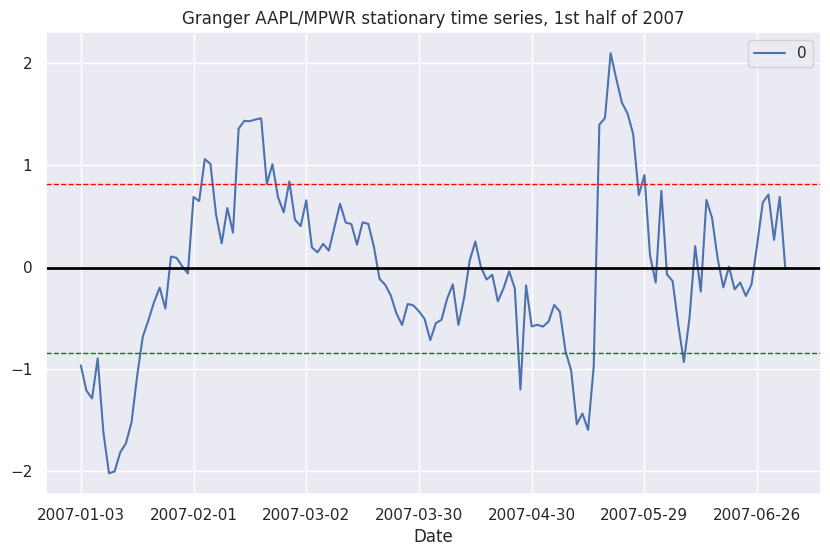

In [6]:

std_dev = stationary_df.std()[0]
plot_stationary_ts(stationary_df=stationary_df, plus_delta=std_dev, minus_delta=std_dev, title='Granger AAPL/MPWR stationary time series, 1st half of 2007' )


<p>
AAPL and MPWR are both technology stocks that have some overlapping businesses (MPWR's products are used by companies like Apple). We would
expect that the two stocks might be cointegrated.
</p>
<p>
The test for cointegration is performed in a lookback period. The next period is the trading period where the close prices of the
pair are combined with the weight (and perhaps the intercept) to form what we hope will be a stationary mean reverting time series
that can be profitably traded.
</p>
<p>
The test below applies the Granger test to the second half of 2007 to see if mean reversion persisted. As the test results shows,
this is not the case.
</p>

In [7]:
second_half_start = d2007_ix+half_year
d2007_aapl_2 = pd.DataFrame(close_prices_df['AAPL']).iloc[second_half_start:second_half_start+half_year]
d2007_mpwr_2 = pd.DataFrame(close_prices_df['MPWR']).iloc[second_half_start:second_half_start+half_year]

coint_data_granger_aapl_mpwr_2 = pair_stat.engle_granger_coint(data_a=d2007_aapl_2, data_b=d2007_mpwr_2)

print(f'Granger test for cointegration (AAPL/MPWR): second half of 2007 {coint_data_granger_aapl_mpwr_2}')

Granger test for cointegration (AAPL/MPWR): second half of 2007 cointegrated: False, confidence: 0, weight: 1.09, intercept: 14.56 (MPWR, AAPL)


<p>
The pair AAPL and YUM (Yum Brands, a food company) would not be expected to be cointegrated (although they have a surprisingly
high correlation). As expected, the Granger test does not show cointegration and mean reversion.
</p>

In [8]:
coint_data_granger_aapl_yum = pair_stat.engle_granger_coint(data_a=d2007_aapl, data_b=d2007_yum)
print(f'Granger test for cointegration (AAPL/YUM): {coint_data_granger_aapl_yum}')


Granger test for cointegration (AAPL/YUM): cointegrated: False, confidence: 0, weight: 2.45, intercept: 13.6 (YUM, AAPL)


<h3>
Correlation and Cointegration
</h3>
<p>
In choosing pairs for pairs trading, we are looking for a stock pair that is influenced by similar factors. Industry sector and high
correlation can be used as a first filter for pairs.
</p>
<p>
The tests for cointegration may find that a pair with a low correlation value is cointegrated and mean reverting. One
example is AAPL and technology sector stock GPN (Global Payments Inc.)  For the first half of 2007, AAPL and GPN have
a low correlation.
</p>

In [9]:
d2007_gpn = pd.DataFrame(close_prices_df['GPN']).iloc[d2007_ix:d2007_ix+half_year]

cor_df = pd.DataFrame([pair_stat.correlation(data_a_df=d2007_aapl, data_b_df=d2007_gpn)])
cor_df.index = ['2007']
cor_df.columns = ['Correlation AAPL/GPN']
print(tabulate(cor_df, headers=[*cor_df.columns], tablefmt='fancy_grid'))

╒══════╤════════════════════════╕
│      │   Correlation AAPL/GPN │
╞══════╪════════════════════════╡
│ 2007 │                   0.32 │
╘══════╧════════════════════════╛


<p>
The normalized close prices for the two stocks in the first half of 2007 are shown below.
</p>

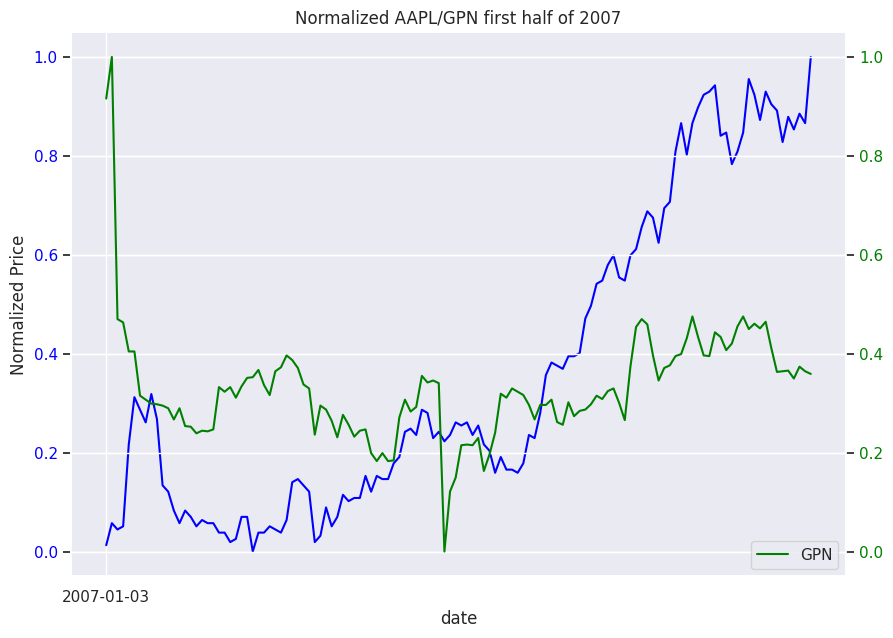

In [10]:
def normalize_df(data_df: pd.DataFrame) -> pd.DataFrame:
    min_s = data_df.min()
    max_s = data_df.max()
    norm_df = (data_df - min_s) / (max_s - min_s)
    return norm_df


d2007_aapl_norm = normalize_df(d2007_aapl)
d2007_gpn_norm = normalize_df(d2007_gpn)

plot_two_ts(data_a=d2007_aapl_norm, data_b=d2007_gpn_norm, title='Normalized AAPL/GPN first half of 2007',x_label='date', y_label='Normalized Price')


<p>
The Granger test shows that AAPL and GPN are cointegrated with 99% confidence (1% error). The Johansen test (see below) also shows
that AAPL and GPN are cointegrated with 99% confidence.
</p>

In [11]:
coint_data_granger_aapl_gpn = pair_stat.engle_granger_coint(data_a=d2007_aapl, data_b=d2007_gpn)
print(f'Granger test for cointegration (AAPL/GPN)  : {coint_data_granger_aapl_gpn}')

Granger test for cointegration (AAPL/GPN)  : cointegrated: True, confidence: 1, weight: 0.56, intercept: 17.52 (GPN, AAPL)


<p>
The plot below shows the stationary time series formed from AAPL and GPN close prices.
</p>

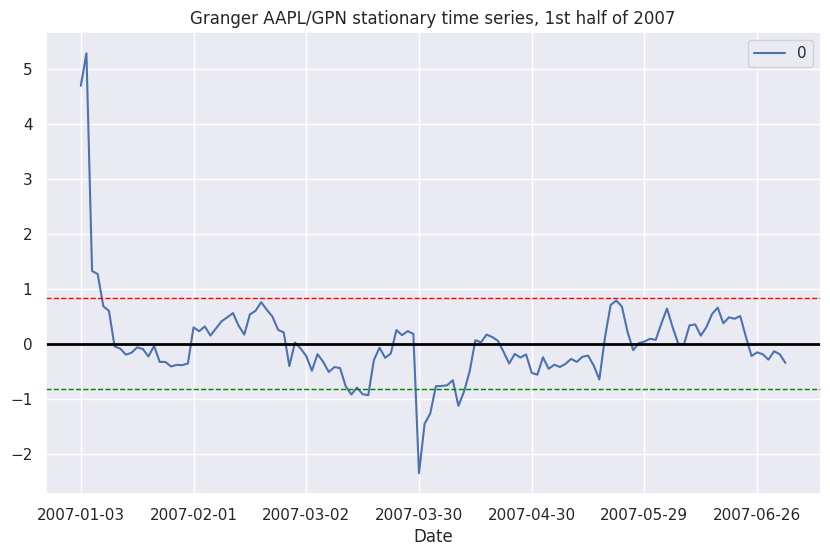

In [12]:
stationary_df = pair_stat.stationary_series(data_a=d2007_aapl, data_b=d2007_gpn, coint_data=coint_data_granger_aapl_gpn)
stat_sd = stationary_df.std()[0]
title='Granger AAPL/GPN stationary time series, 1st half of 2007'
plot_stationary_ts(stationary_df=stationary_df, plus_delta=stat_sd, minus_delta=stat_sd, title=title)

<p>
Given their low correlation and unrelated businesses (computer and media hardware vs payments) this may be an example of spurious
cointegration. If the cointegratoin is spurious, cointegration may be more likely to break down in a future time period and the
pair may not be profitable to trade.
</p>
<p>
The Granger test for the second half of 2007 (e.g., the six months following the period above) is shown below:
</p>

In [13]:

d2007_gpn_2 = pd.DataFrame(close_prices_df['GPN']).iloc[second_half_start:second_half_start+half_year]
coint_data_granger_aapl_gpn_2 = pair_stat.engle_granger_coint(data_a=d2007_aapl_2, data_b=d2007_gpn_2)

print(f'Granger test for cointegration (AAPL/GPN): second half of 2007 {coint_data_granger_aapl_gpn_2}')

Granger test for cointegration (AAPL/GPN): second half of 2007 cointegrated: False, confidence: 0, weight: 1.68, intercept: 11.46 (GPN, AAPL)


<p>
The Granger test shows that there is no cointegration in the six momnth period following the first half of 2007, which reinforces the idea
that the previous cointegration was spurious.
</p>
<h3>
The Johansen Test
</h3>
<p>
The Granger linear regression based test can only be used for two assets. The Johansen test can be used on more than two assets.
</p>
<p>
The Johansen test uses eigenvalue decomposition for the estimation of cointegration. In contrast to the Granger test which has two steps:
linear regression and the ADF test, the Johansen test is a single step test that also provides the weight factors. There is no linear
constant (regression intercept) as there is with the Granger test, so the Johansen result may not have a mean of zero.
</p>
<p>
The Johansen test and the Granger test do not always agree. The Johansen test is applied to AAPL/MPWR for the close prices from the first
half of 2007. The Johansen test shows no cointegration, although the Granger test showed cointegration at the 99% confidence level.
</p>

In [14]:
coint_data_johansen_aapl_mpwr = pair_stat.johansen_coint(data_a=d2007_aapl, data_b=d2007_mpwr)
print(f'Johansen test for cointegration (AAPL/MPWR), first half of 2007 : {coint_data_johansen_aapl_mpwr}')

Johansen test for cointegration (AAPL/MPWR), first half of 2007 : cointegrated: False, confidence: 0, weight: 3.71, (AAPL, MPWR)


<p>
In the research papers on cointegration, there doesn't seem to be a consensus on whether the Granger or
Johansen tests are better. Some authors suggest using both tests, but they don't provide any empirical insight into why this might be advantageous.
</p>

<h2>
Correlation
</h2>
<p>
After selecting stocks based on their industry sector, the next filter used is the pair correlation of the close prices.
</p>
<p>
Stocks that are strongly correlated are more likely to also exhibit mean reversion since they have similar market behavior.
This section examines the correlation statistics for the S&P 500 sector pairs.
</p>


In [15]:


def get_pairs(sector_info: dict) -> List[Tuple]:
    """
    Return the sector stock pairs, where the pairs are selected from the S&P 500 sector.

    :param sector_info: A dictionary containing the sector info. For example:
                        energies': ['APA', 'BKR', 'COP', ...]
                       Here 'energies' is the dictionary key for the S&P 500 sector. The dictionary value is the
                       list of stocks in the sector.

    :return: A list of Tuples, where each tuple contains the symbols for the stock pair and the sector.
            For example:
              [('AAPL', 'ACN', 'information-technology'),
               ('AAPL', 'ADBE', 'information-technology'),
               ('AAPL', 'ADI', 'information-technology'),
               ('AAPL', 'ADP', 'information-technology'),
               ('AAPL', 'ADSK', 'information-technology')]
    """
    pairs_list = list()
    sectors = list(sector_info.keys())
    for sector in sectors:
        stocks = sector_info[sector]
        num_stocks = len(stocks)
        for i in range(num_stocks):
            stock_a = stocks[i]
            for j in range(i + 1, num_stocks):
                stock_b = stocks[j]
                pairs_list.append((stock_a, stock_b, sector))
    return pairs_list


def display_histogram(data_v: np.array, x_label: str, y_label: str) -> None:
    num_bins = int(np.sqrt(data_v.shape[0])) * 4
    fix, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)
    ax.hist(data_v, bins=num_bins, color="blue", ec="blue")
    plt.show()


In [16]:

class SerialCorrelation:
    class SerialCorrResult:
        def __init__(self, pair: Tuple, corr_df: pd.DataFrame):
            self.pair: Tuple = pair
            self.corr_df: pd.DataFrame = corr_df

    def __init__(self, stock_close_df: pd.DataFrame, pairs_list: List[Tuple], window: int):
        self.stock_close_df = stock_close_df
        self.pairs_list = pairs_list
        self.window = window
        self.index = self.stock_close_df.index

    def calc_pair_serial_correlation(self, pair) -> SerialCorrResult:
        stock_a_sym = pair[0]
        stock_b_sym = pair[1]
        stock_a_df = self.stock_close_df[stock_a_sym]
        stock_b_df = self.stock_close_df[stock_b_sym]
        corr_list = list()
        date_list = list()
        for ix in range(0, self.stock_close_df.shape[0], self.window):
            stock_a_win = log(stock_a_df.iloc[ix:ix + self.window])
            stock_b_win = log(stock_b_df.iloc[ix:ix + self.window])
            c = np.corrcoef(stock_a_win, stock_b_win)
            corr =  round(c[0, 1], 2)
            corr_list.append(corr)
            date_list.append(self.index[ix])
        corr_df = pd.DataFrame(corr_list)
        corr_df.index = date_list
        serial_corr_result = self.SerialCorrResult(pair, corr_df)
        return serial_corr_result

    def build_corr_frame(self, corr_list: List[SerialCorrResult]) -> pd.DataFrame:
        num_cols = len(corr_list)
        num_rows = corr_list[0].corr_df.shape[0]
        corr_m = np.zeros([num_rows, num_cols])
        col_names = list()
        for col_ix in range(num_cols):
            pair = corr_list[col_ix].pair
            col = f'{pair[0]}:{pair[1]}'
            col_names.append(col)
            corr_df = corr_list[col_ix].corr_df
            for row_ix in range(num_rows):
                corr_m[row_ix, col_ix] = corr_df.iloc[row_ix]
        corr_df = pd.DataFrame(corr_m)
        corr_df.columns = col_names
        corr_df.index = corr_list[0].corr_df.index
        return corr_df


    def serial_correlation(self) -> pd.DataFrame:
        # serial_corr_list = list()
        # for pair in self.pairs_list:
        #     serial_corr = self.calc_pair_serial_correlation(pair)
        #     serial_corr_list.append(serial_corr)
        with Pool() as mp_pool:
            serial_corr_list = mp_pool.map(self.calc_pair_serial_correlation, self.pairs_list)
        corr_df = self.build_corr_frame(serial_corr_list)
        return corr_df


pairs_list = get_pairs(sectors)

serial_correlation = SerialCorrelation(close_prices_df, pairs_list, half_year)

apple_tuple: Tuple = ('AAPL', 'MPWR')
apple_corr_result: SerialCorrelation.SerialCorrResult = serial_correlation.calc_pair_serial_correlation(apple_tuple)
apple_corr_df = apple_corr_result.corr_df


<p>
The lookback period for pairs selection is six months (126 trading days). As a first step, all of the S&P 500 sector
pairs will be tested for correlation over the lookback period.
</p>
<p>
Correlation is calculated price for each stock pair.
</p>
<p>
The windowed correlation is not stable. The plot below shows the correlation between two stocks, AAPL and MPWR, over windowed
periods from the start date.
</p>

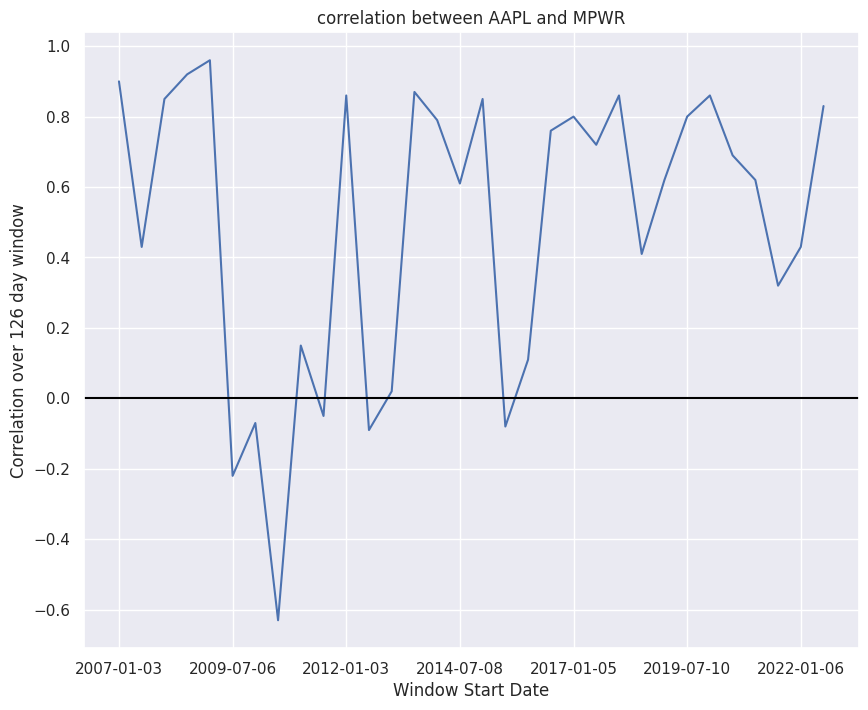

In [17]:


plot_ts(data_s=apple_corr_df[0], title=f'correlation between {apple_tuple[0]} and {apple_tuple[1]}',
        x_label='Window Start Date', y_label=f'Correlation over {half_year} day window')


<p>
Since correlation is not stable, a stock pair that is highly correlated in one time period may be uncorrelated (or negatively
correlated) in the next time period.
</p>


In [18]:


corr_df = serial_correlation.serial_correlation()


def calc_corr_dist(corr_df: pd.DataFrame, cut_off: float) -> pd.DataFrame:
    count_list = list()
    for row_num, row in corr_df.iterrows():
        count = 0
        for val in row:
            if val >= cut_off:
                count = count + 1
        count_list.append(count)
    count_df = pd.DataFrame(count_list)
    count_df.index = corr_df.index
    return count_df


cor_a = np.array(corr_df.values).ravel()


<p>
The histogram below shows the aggregate distribution of the pair correlation over all half year time periods.
</p>

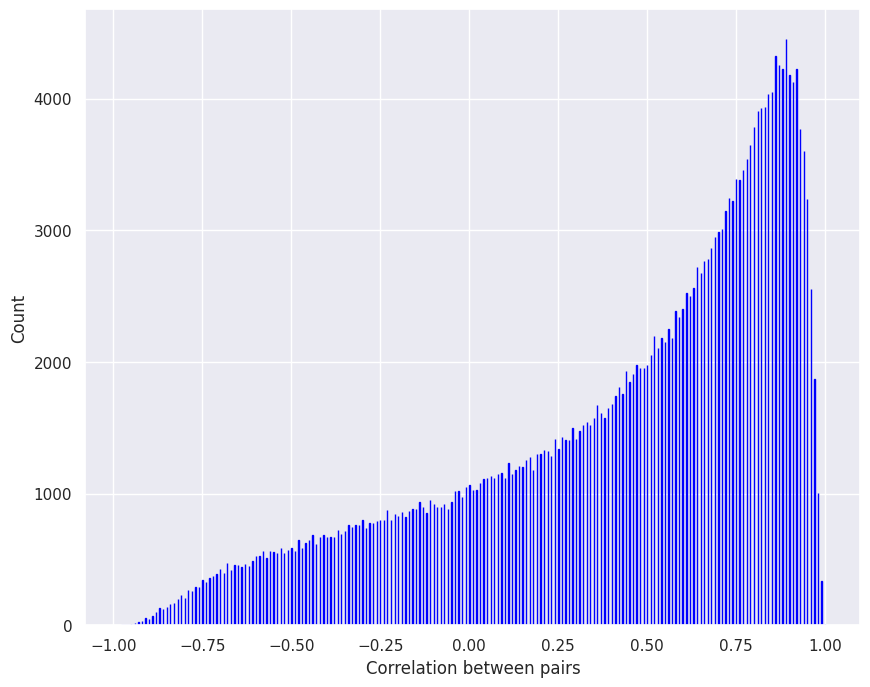

In [19]:


display_histogram(cor_a, 'Correlation between pairs', 'Count')


<p>
The pairs are selected from a common S&P industry sector, so there are a significant number of pairs that
have a correlation above 0.75.
</p>
<p>
There are a small number of pairs that have a strong negative correlation (a negative correlation -0.75 to approximately -0.9).
Initially we look at pairs that have a strong positive correlation, but it may be unwise to ignore the negative correlations as
well.
</p>
<p>
The plot below shows the number of pairs, in a half year time period, with a correlation above a particular cutoff.
</p>

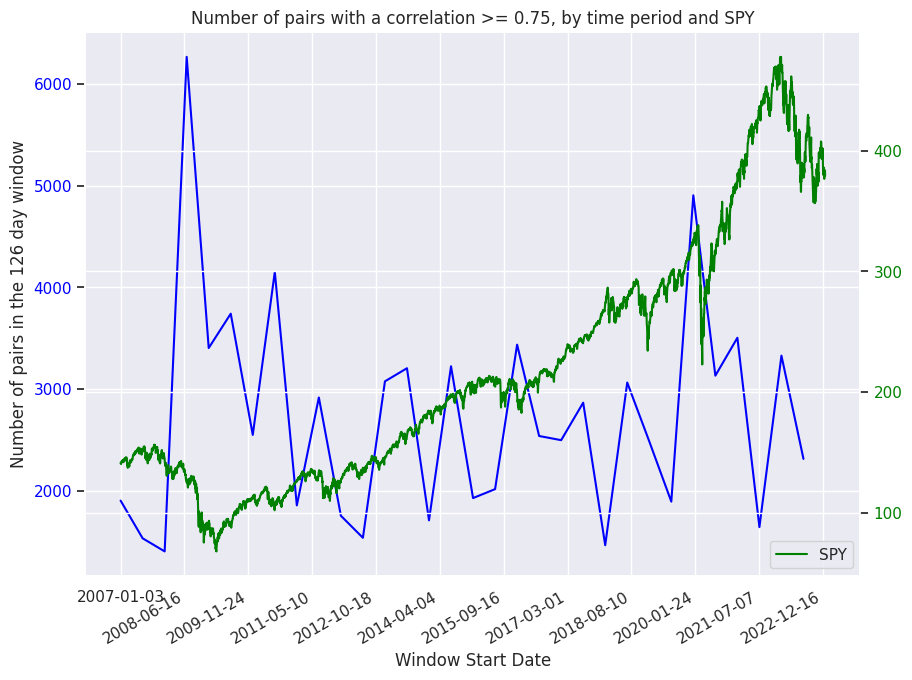

In [20]:

correlation_cutoff = 0.75
cor_dist_df = calc_corr_dist(corr_df, correlation_cutoff)


spy_close_df = market_data.read_data('SPY')
spy_close_df = pd.DataFrame(spy_close_df[spy_close_df.columns[0]])
cor_dist_df.columns = ['Correlation']


plot_two_ts(data_a=cor_dist_df, data_b=spy_close_df, title=f"Number of pairs with a correlation >= {correlation_cutoff}, by time period and SPY",
            x_label='Window Start Date', y_label=f'Number of pairs in the {half_year} day window')



<p>
In the plot above, about 75% of the pairs are highly correlated around 2008. This corresponds to the 2008–2009 stock market crash caused by the financial crisis. The high correlation around the crash lends validity to the financial market maxim that in a market crash, all assets become correlated.
</p>
<p>
To the extent that correlation is a predictor for mean reversion, this also suggests that mean reversion statistics may be volatile.
</p>

In [21]:
class CalcPairsCointegration:
    def __init__(self, close_prices_df: pd.DataFrame):
        self.close_prices_df = close_prices_df
        self.pair_stat = PairStatistics()
        self.coint_matrix_io = CointMatrixIO()

    def compute_halflife(self, z_df: pd.DataFrame) -> int:
        """
        Calculate the half-life of a mean reverting stationary series where the series
        is an Ornstein–Uhlenbeck process
        From example 7.5 in Quantitative Trading by Ernest P. Chan
        """
        prevz = z_df.shift()
        dz = z_df - prevz
        dz = dz[1:]
        prevz = prevz[1:]
        norm_prevz = prevz - np.mean(prevz.values)
        result = sm.OLS(dz, norm_prevz).fit()
        theta = result.params
        halflife_f = -np.log(2) / theta
        halflife = round(halflife_f, 0)
        return int(halflife)

    def calc_pair_coint(self, pair_str: str, window_start: int, window: int) -> CointAnalysisResult:
        pair_l = pair_str.split(':')
        asset_a = pd.DataFrame(
            self.close_prices_df[pair_l[0]].iloc[window_start:window_start + window])
        asset_b = pd.DataFrame(
            self.close_prices_df[pair_l[1]].iloc[window_start:window_start + window])
        granger_coint = self.pair_stat.engle_granger_coint(asset_a, asset_b)
        asset_a_str = asset_a.columns[0]
        asset_b_str = asset_b.columns[0]
        if asset_a_str != granger_coint.asset_a:
            t = asset_a_str
            asset_a_str = asset_b_str
            asset_b_str = t
        granger_pair_str = f'{asset_a_str}:{asset_b_str}'
        granger_coint_info = CointInfo(pair_str=granger_pair_str,
                                       confidence=granger_coint.confidence,
                                       weight=granger_coint.weight,
                                       has_intercept=True,
                                       intercept=granger_coint.intercept)
        johansen_coint = self.pair_stat.johansen_coint(asset_a, asset_b)
        johansen_coint_info = CointInfo(pair_str=pair_str,
                                        confidence=johansen_coint.confidence,
                                        weight=johansen_coint.weight,
                                        has_intercept=False,
                                        intercept=np.NAN)
        coint_result = CointAnalysisResult(granger_coint=granger_coint_info, johansen_coint=johansen_coint_info)
        return coint_result

    def calc_pairs_coint_dataframe(self, corr_df: pd.DataFrame, window: int) -> pd.DataFrame:
        """
        :param corr_df: a data frame of pairs correlation values, where the index is the date and
                        the columns are the pairs
        :param window:  the look back window
        :return: a data frame of tuples composed of a correlation value and the granger and johansen cointegration
                 objects.
        """
        if self.coint_matrix_io.has_files():
            coint_info_df = self.coint_matrix_io.read_files()
        else:
            coint_info_a = np.zeros(corr_df.shape, dtype='O')
            pairs_l = list(corr_df.columns)
            window_start = 0
            for row_ix in range(corr_df.shape[0]):
                print(f'CalcPairsCointegration::calc_pairs_coint_dataframe: processing row {row_ix}')
                for col_ix in range(corr_df.shape[1]):
                    pair_str = pairs_l[col_ix]
                    coint_info = self.calc_pair_coint(pair_str=pair_str, window_start=window_start, window=window)
                    correlation = corr_df.iloc[row_ix, col_ix]
                    coint_info_a[row_ix, col_ix] = (correlation, coint_info)
                window_start = window_start + window
            coint_info_df = pd.DataFrame(coint_info_a)
            coint_info_df.columns = corr_df.columns
            coint_info_df.index = corr_df.index
            self.coint_matrix_io.write_files(coint_info_df)
        return coint_info_df


class Statistics:
    def __init__(self):
        # Total number of pairs with correlation >= cutoff
        self.total_correlation = 0
        # Total for serial correlation where elem_n is greater than or equal to the cutoff
        # and elem_n_1 is greater than or equal to cutoff 2
        self.serial_correlation = 0
        # Total pairs - the size of the data frame: shape[0] * shape[1]
        self.total_pairs: int = 0
        # Serial cointegrated pairs count by time period
        self.pair_count_df = pd.DataFrame()
        #
        # Lists for correlation/cointegration distribution
        #
        # Correlation with Granger cointegration
        self.corr_granger: List = list()
        # Correlation with Johansen cointegration
        self.corr_johansen: List = list()
        # A list of correlation values where the value is associated with Granger OR Johansen cointegration
        # The length of this list is the total cointegration number
        self.corr_granger_or_johansen: List = list()
        # A list of correlation values where the value is associated with Granger AND Johansen cointegration
        self.corr_granger_and_johansen: List = list()
        #
        # Correlation/Cointegration counts
        #
        # Total number of pairs that have correlation >= cutoff and Granger cointegration
        self.total_corr_granger: int = 0
        # Total number of pairs that have correlation >= cutoff and Johansen cointegration
        self.total_corr_johansen: int = 0
        # Total number of pairs that have correlation >= cutoff and Granger OR Johansen cointegration
        self.total_corr_granger_or_johansen = 0
        # Total number of pairs that have correlation >= cutoff and Granger ANd Johansen cointegration
        self.total_corr_granger_and_johansen = 0
        #
        # Serial cointegration
        #
        # Number of pairs with in-sample correlation >= cutoff, in-sample granger and serial cointegration
        self.corr_granger_serial_coint: int = 0
        # Number of pairs with in-sample correlation >= cutoff, in-smaple Johansen and serial cointegratoin
        self.corr_johansen_serial_coint: int = 0
        # Number of pairs with in-sample correlation >= cutoff, in-sample Granger or Johansen and serial cointegration
        self.granger_or_johansen_serial_coint: int = 0
        # Number of pairs with in-sample correlation >= cutoff, in-sample Granger AND Johansen and serial cointegration
        self.granger_and_johansen_serial_coint: int = 0
        # Number of pairs with correlation >= cutoff and in-sample granger = 90
        self.granger_coint_90: int = 0
        # Number of pairs with correlation >= cutoff, in-sample granger = 90 and serial cointegrated
        self.granger_serial_coint_90: int = 0
        # Number of pairs with correlation >= cutoff and in-sample granger = 95
        self.granger_coint_95: int = 0
        # Number of pairs with correlation >= cutoff, in-sample granger = 95 and serial cointegrated
        self.granger_serial_coint_95: int = 0
        # Number of pairs with correlation >= cutoff and in-sample granger = 99
        self.granger_coint_99: int = 0
        # Number of pairs with correlation >= cutoff, in-sample granger = 99 and serial cointegrated
        self.granger_serial_coint_99: int = 0
        # Number of pairs with correlation >= cutoff and in-sample Johansen = 90
        self.johansen_coint_90: int = 0
        # Number of pairs with correlation >= cutoff, in-sample johansen = 90 and serial cointegrated
        self.johansen_serial_coint_90: int = 0
        # Number of pairs with correlation >= cutoff and in-sample Johansen = 95
        self.johansen_coint_95: int = 0
        # Number of pairs with correlation >= cutoff, in-sample johansen = 95 and serial cointegrated
        self.johansen_serial_coint_95: int = 0
        # Number of pairs with correlation >= cutoff and in-sample Johansen = 99
        self.johansen_coint_99: int = 0
        # Number of pairs with correlation >= cutoff, in-sample johansen = 99 and serial cointegrated
        self.johansen_serial_coint_99: int = 0



class CalcStatistics:
    def __init__(self, cutoff: float, cutoff_2: float) -> None:
        self.cutoff = cutoff
        self.cutoff_2 = cutoff_2

    def add_coint_stats(self,
                        correlation_n: float,
                        is_n_granger_coint: bool,
                        is_n_johansen_coint: bool,
                        stats: Statistics) -> None:
        """
        Collect the relationship between Granger and Johansen cointegration and correlation
        in the in-sample data.
        :param correlation_n: The correlation for the in-sample data
        :param is_n_granger_coint: whether the in-sample data shows Granger cointegration
        :param is_n_johansen_coint: whether the in-smaple data shows Johansen cointegration
        :param stats: the statistics object
        :return: nothing
        """
        is_n_either_coint = is_n_granger_coint or is_n_johansen_coint
        is_n_both_coint = is_n_granger_coint and is_n_johansen_coint
        if is_n_granger_coint:
            stats.corr_granger.append(correlation_n)
        if is_n_johansen_coint:
            stats.corr_johansen.append(correlation_n)
        if is_n_either_coint:
            stats.corr_granger_or_johansen.append(correlation_n)
        if is_n_both_coint:
            stats.corr_granger_and_johansen.append(correlation_n)

    def correlation_and_cointegration(self,
                                      is_n_granger_coint: bool,
                                      is_n_johansen_coint: bool,
                                      is_n_1_granger_coint: bool,
                                      is_n_1_johansen_coint: bool,
                                      stats: Statistics,
                                      period,
                                      pairs_dict: Dict) -> None:
        n_1_cointegration = is_n_1_granger_coint or is_n_1_johansen_coint
        # Total number of pairs that have correlation >= cutoff and Granger cointegration
        if is_n_granger_coint:
            stats.total_corr_granger += 1
            count: int = pairs_dict[period]
            pairs_dict[period] = count + 1
            # Number of pairs with in-smaple correlation >= cutoff, in-sample granger and serial cointegration
            if n_1_cointegration:
                stats.corr_granger_serial_coint += 1
        # Total number of pairs that have correlation >= cutoff and Johansen cointegration
        if is_n_johansen_coint:
            stats.total_corr_johansen += 1
            if n_1_cointegration:
                # Number of pairs with in-sample correlation >= cutoff, in-smaple Johansen and serial cointegratoin
                stats.corr_johansen_serial_coint += 1
        # Total number of pairs that have correlation >= cutoff and Granger OR Johansen cointegration
        if is_n_granger_coint or is_n_johansen_coint:
            stats.total_corr_granger_or_johansen += 1
            if n_1_cointegration:
                # Number of pairs with in-sample correlation >= cutoff, in-sample Granger or Johansen and serial cointegration
                stats.granger_or_johansen_serial_coint += 1
        if is_n_granger_coint and is_n_johansen_coint:
            stats.total_corr_granger_and_johansen += 1
            if n_1_cointegration:
                # Number of pairs with in-sample correlation >= cutoff, in-sample Granger AND Johansen and serial cointegration
                stats.granger_and_johansen_serial_coint += 1


    def confidence_stats(self, elem_n_coint: CointAnalysisResult,
                         elem_n_1_coint: CointAnalysisResult,
                         stats: Statistics) -> None:
        granger_n_conf: int = elem_n_coint.granger_coint.confidence
        granger_n_1_conf: int = elem_n_1_coint.granger_coint.confidence
        johansen_n_conf: int = elem_n_coint.johansen_coint.confidence
        johansen_n_1_conf: int = elem_n_1_coint.johansen_coint.confidence
        either_n_1_coint = granger_n_1_conf > 0 or johansen_n_1_conf > 0
        match granger_n_conf:
            case 10:
                stats.granger_coint_90 += 1
                if either_n_1_coint:
                    # Number of pairs with correlation >= cutoff, in-sample granger = 90 and serial cointegrated
                    stats.granger_serial_coint_90 += 1
            case 5:
                stats.granger_coint_95 += 1
                if either_n_1_coint:
                    stats.granger_serial_coint_95 += 1
            case 1:
                stats.granger_coint_99 += 1
                if either_n_1_coint:
                    stats.granger_serial_coint_99 += 1
        match johansen_n_conf:
            case 10:
                stats.johansen_coint_90 += 1
                if either_n_1_coint:
                    stats.johansen_serial_coint_90 += 1
            case 5:
                stats.johansen_coint_95 += 1
                if either_n_1_coint:
                    stats.johansen_serial_coint_95 += 1
            case 1:
                stats.johansen_coint_99 += 1
                if either_n_1_coint:
                    stats.johansen_serial_coint_99 += 1

    def col_stats(self,
                  elem_n_tuple: Tuple,
                  elem_n_1_tuple: Tuple,
                  stats: Statistics,
                  period,
                  pairs_dict: Dict) -> None:
        correlation_n = elem_n_tuple[0]
        elem_n_coint: CointAnalysisResult = elem_n_tuple[1]
        elem_n_1_coint: CointAnalysisResult = elem_n_1_tuple[1]
        elem_n_granger = elem_n_coint.granger_coint
        is_n_granger_coint = elem_n_granger.confidence > 0
        elem_n_1_granger = elem_n_1_coint.granger_coint
        is_n_1_granger_coint = elem_n_1_granger.confidence > 0
        #
        elem_n_johansen = elem_n_coint.johansen_coint
        is_n_johansen_coint = elem_n_johansen.confidence > 0
        elem_n_1_johansen = elem_n_1_coint.johansen_coint
        is_n_1_johansen_coint = elem_n_1_johansen.confidence > 0
        self.add_coint_stats(correlation_n,
                             is_n_granger_coint,
                             is_n_johansen_coint,
                             stats)
        if correlation_n >= self.cutoff:
            stats.total_correlation += 1
            correlation_n_1 = elem_n_1_tuple[0]
            if correlation_n_1 >= self.cutoff_2:
                stats.serial_correlation += 1
            self.correlation_and_cointegration(is_n_granger_coint,
                                               is_n_johansen_coint,
                                               is_n_1_granger_coint,
                                               is_n_1_johansen_coint,
                                               stats,
                                               period,
                                               pairs_dict)
            self.confidence_stats(elem_n_coint, elem_n_1_coint, stats)


    def build_pairs_dict(self, coint_info_df: pd.DataFrame) -> Dict:
        pairs_dict = dict()
        index = coint_info_df.index
        for time_stamp in index:
            pairs_dict[time_stamp]: int = 0
        return pairs_dict


    def traverse(self, coint_info_df: pd.DataFrame) -> Statistics:
        stats = Statistics()
        pairs_dict: Dict = self.build_pairs_dict(coint_info_df)
        index = coint_info_df.index
        rows = coint_info_df.shape[0]
        cols = coint_info_df.shape[1]
        stats.total_pairs = rows * cols
        for col_ix in range(cols):
            for row_ix in range(rows-1):
                elem_n_tuple: Tuple = coint_info_df.iloc[row_ix, col_ix]
                elem_n_1_tuple: Tuple = coint_info_df.iloc[row_ix+1, col_ix]
                period = index[row_ix]
                self.col_stats(elem_n_tuple, elem_n_1_tuple, stats, period, pairs_dict)
        counts = pairs_dict.values()
        pair_count_df = pd.DataFrame(counts)
        pair_count_df.index = index
        pair_count_df.columns = ['Pairs Count']
        stats.pair_count_df = pair_count_df.iloc[:-1]
        return stats



cointegration_calc = CalcPairsCointegration(close_prices_df=close_prices_df)
coint_info_df = cointegration_calc.calc_pairs_coint_dataframe(corr_df=corr_df, window=half_year)

calc_statistics = CalcStatistics(cutoff=correlation_cutoff, cutoff_2=correlation_cutoff-0.10)
stats = calc_statistics.traverse(coint_info_df=coint_info_df)

<h2>
Correlation Statistics
</h2>
<p>
This section looks at correlation statistics and their relation to cointegration:
</p>
<ul>
<li>
<p>
Stability of pairs correlation. When there is high pairs correlation (correlation greater than or equal to 0.75) in the past six months,
how often is there correlation in the next time period (correlation >= 0.60)?
</p>
</li>
<li>
<p>
Is pairs correlation related to cointegration? For example, is high correlation related to cointegration?
</p>
</li>
</ul>
<h3>
Stability of Correlation
</h3>
<p>
For pairs trading to be a profitable strategy the statistics that are observed over a past period must persist into the next time period often
enough to be profitable.  If a pairs forms a stationary mean reverting time series in a past period, profitable pairs trading relies
on this statistic holding over the out-of-sample trading period (often enough to be profitable).
</p>
<p>
In this section I look at whether a strong correlation between pairs makes it likely that there will be a strong correlation in
the next time period. This is an important statistic for pairs trading because correlation is related to cointegration. If correlation persists
between periods then cointegration and mean reversion are more likely to persist. If correlation does not persist between time periods
then cointegration may not be persistent.
</p>
<p>
The table below shows the dependence between correlation in the past period and correlation in the next period. The correlation is the
past period is at least 0.75. The correlation in the next period is at least 0.60.
</p>

In [22]:
correlation_percent = round((stats.serial_correlation/stats.total_correlation) * 100, 2)
correlation_depend_df = pd.DataFrame([stats.total_correlation, stats.serial_correlation, correlation_percent]).transpose()
correlation_depend_df.columns = [f'Total Correlation >= {correlation_cutoff}', f'Serial Correlation >= {correlation_cutoff-0.10}', 'percent']

print(tabulate(correlation_depend_df, headers=[*correlation_depend_df.columns], tablefmt='fancy_grid'))

╒════╤═════════════════════════════╤══════════════════════════════╤═══════════╕
│    │   Total Correlation >= 0.75 │   Serial Correlation >= 0.65 │   percent │
╞════╪═════════════════════════════╪══════════════════════════════╪═══════════╡
│  0 │                       85220 │                        41616 │     48.83 │
╘════╧═════════════════════════════╧══════════════════════════════╧═══════════╛


<p>
As the table above shows, about half (~49%) of the pairs with a high correlation are also highly correlated in the next time period.
</p>

<h3>
Computation
</h3>
<p>
For every pair the correlation, granger cointegration and johansen cointegration are calculated. The calculation is very compute intensive
and Python is notorious for being slow compared to C++ and Java (Python does, however, have lots of support for statistics and data analysis).
I have only succeeded in successfully doing this calculation in a single Python thread.  I tried to use Python's Pool parallelism which would
allow me to run the calculation in parallel on the 16-CPU cores on my Linux system. Unfortunately this resulted in a segment fault
causing the calculation to fail.
</p>
<p>
The historical calculation is constant (since the historical data is constant). To avoid recalculating the correlation and cointegration
data, the values are stored in files. A Pandas DataFrame is constructed from this data.
</p>
<p>
The data in these files can be recalculated by removing the files and running the notebook.
</p>

<h3>
Correlation and Cointegration
</h3>
<p>
After filtering for the S&P 500 industry sector, the next filter that is used in pair selection is correlation (i.e., pairs with
high correlation are selected for cointegration testing).
</p>
<p>
The histograms below show the relationship between correlation and cointegration, in the same half-year, in-sample period.
</p>

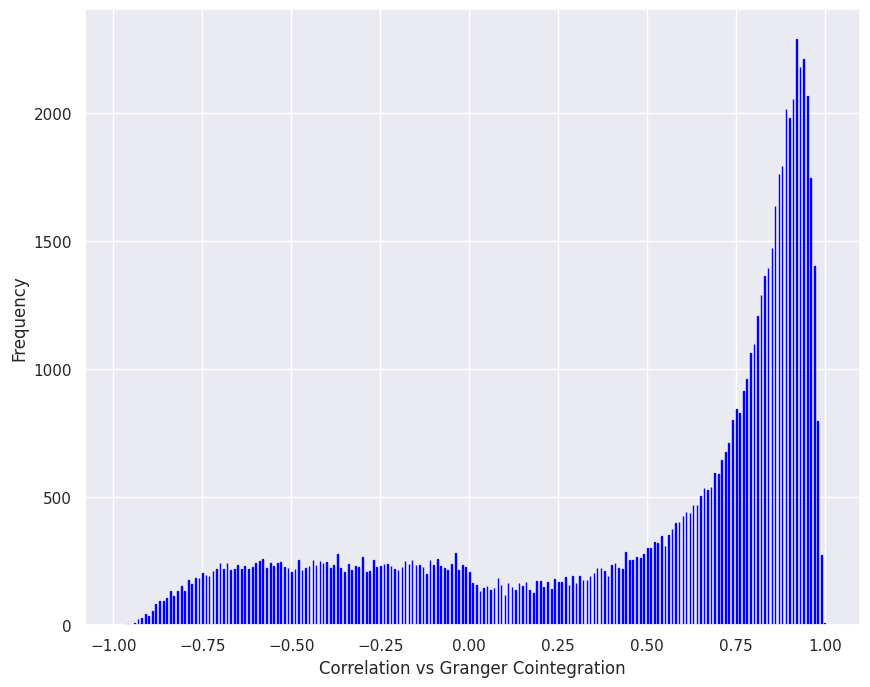

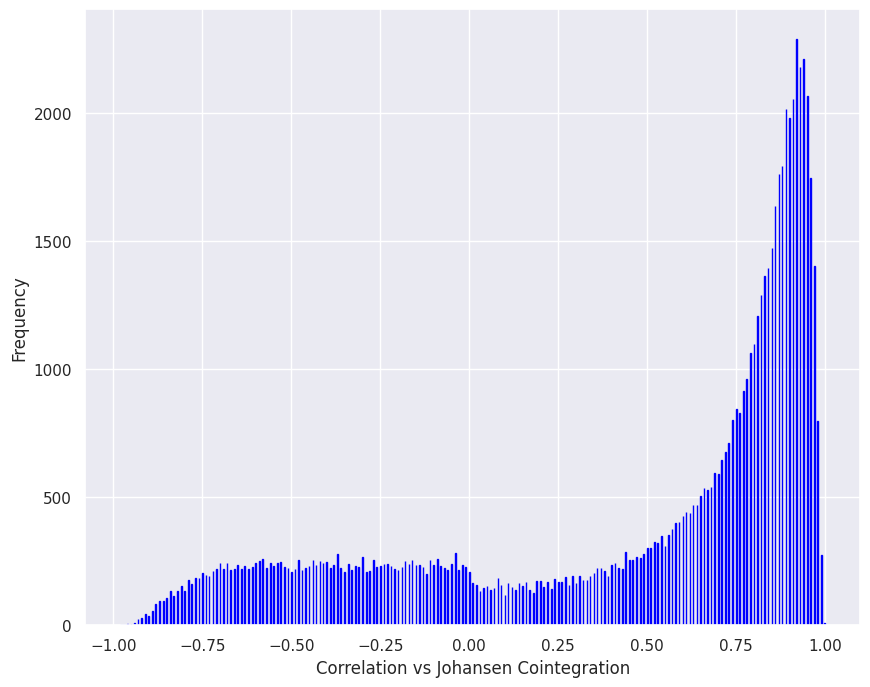

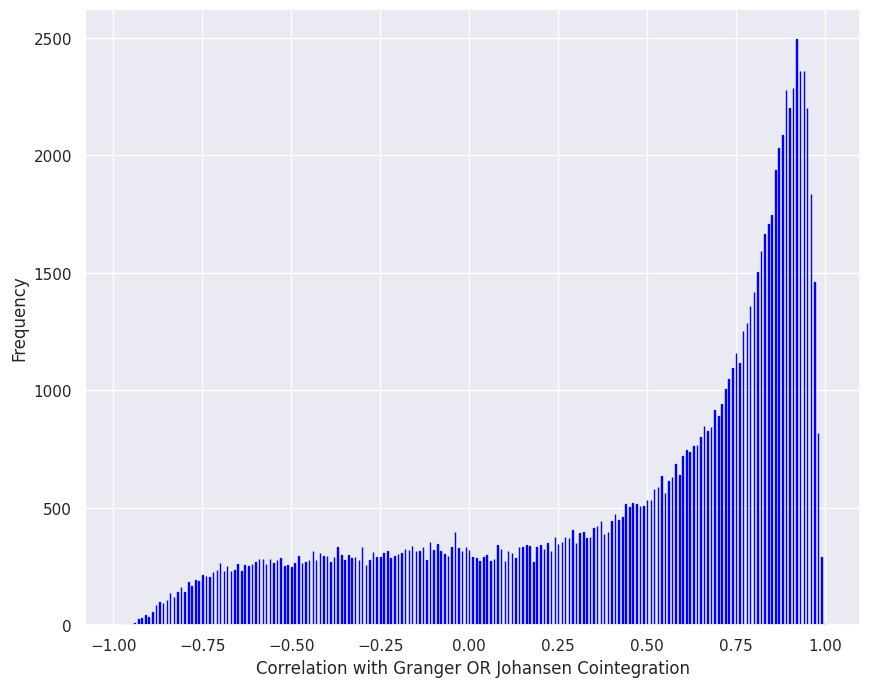

In [23]:
correlation_granger_a = np.array(stats.corr_granger)
display_histogram(correlation_granger_a, 'Correlation vs Granger Cointegration', 'Frequency')

correlation_johansen_a = np.array(stats.corr_johansen)
display_histogram(correlation_granger_a, 'Correlation vs Johansen Cointegration', 'Frequency')

correlation_and_cointegration_a = np.array(stats.corr_granger_or_johansen)
display_histogram(correlation_and_cointegration_a, 'Correlation with Granger OR Johansen Cointegration', 'Frequency')

<p>
The histogram plot above shows that there is a strong relationship between correlation and cointegration. That is, highly correlated
pairs are more likely to be cointegrated.
</p>
<p>
The histogram also shows that there are cointegration is much more common with higher positive correlation.
</p>
<p>
The histogram below shows the relationship between correlation and cointegration where cointegration meets both the Granger
and Johansen tests (e.g., Granger AND Johansen cointegration).
</p>

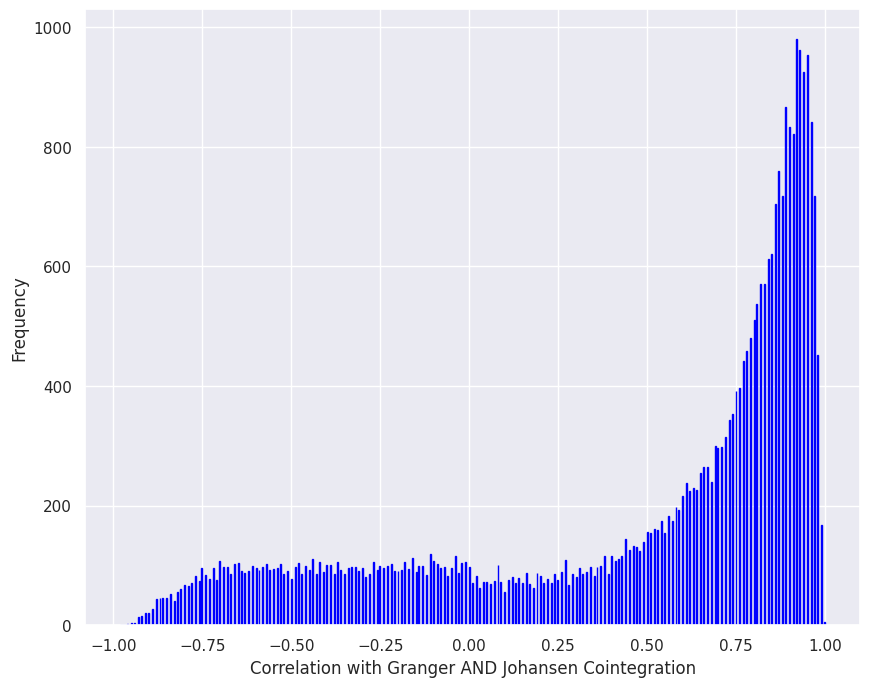

In [24]:

correlation_granger_and_johansen_a = np.array(stats.corr_granger_and_johansen)
display_histogram(correlation_granger_and_johansen_a, 'Correlation with Granger AND Johansen Cointegration', 'Frequency')




<p>
The histograms above show that correlation is an effective first filter for cointegration.
</p>
<p>
The histogram below shows the number of pairs that are highly correlated with Granger cointegration for each in-sample
time period.
</p>

<AxesSubplot: xlabel='Date'>

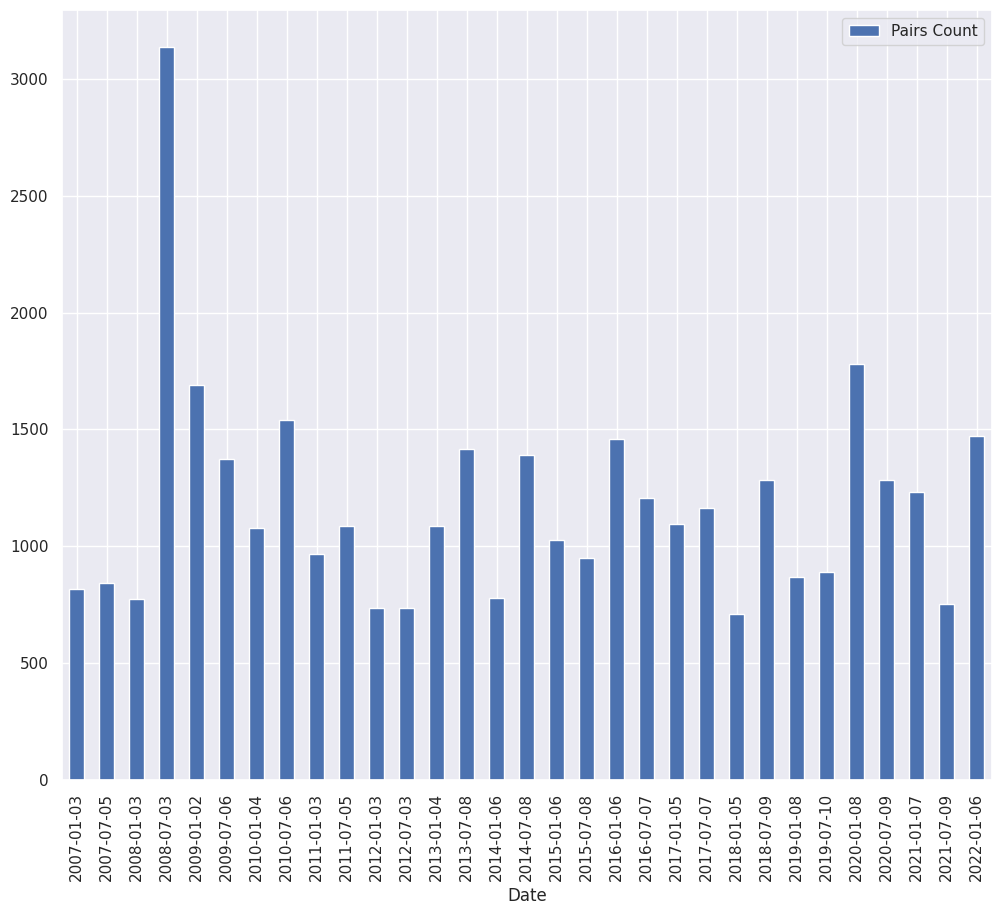

In [25]:
stats.pair_count_df.plot(kind='bar', figsize=(12,10))

<p>
As we have seen, correlation increases in market crashes. The histogram above suggests that cointegration increases as well.
</p>

<h2>
Stability of Cointegration
</h2>
<p>
Cointegration for a pair is calculated over an in-sample look-back period. When a pair is found to be cointegrated, trading takes place
in the out-of-sample period. For example, cointegration is calculated over a half year look-back period. Trading, using the cointegration spread,
takes place over a three month out-of-sample period following the look-back period.
</p>
<p>
For a cointegrated pair, the spread time series is a stationary time series with a constant mean and standard deviation.
The spread time series is mean reverting, so that divergences from the mean return to the mean. The statistics of the spread time series,
in an ideal world, are consistent between the look-back period and the trading period.
</p>
<p>
In the real world, stock and stock pair behavior is constantly changing.  For pairs trading to succeed in the real world (as opposed to
the ideal world), the mean reversion of the spread time series must persist (be stationary) between the look-back period and the trading
period often enough to yield a profit.
</p>
<p>
There is no way to know if a pair will remain stationary between the look-back period and the trading period. What can be examined
are the historical frequences where there is stationarity between the look-back period and the trading period.
</p>
<p>
There are a limited number of six month time periods. Looking at the stationarity for a single pair would not be statistically
significant, but we can look over all 8863 pairs over 32 time periods.
</p>
<p>
The histogram below shows the relationship between past correlation and serial cointegration. Here cointegration is either Granger
or Johansen cointegration.
</p>

In [26]:
coint_totals = np.array([# Total number of pairs that have correlation >= cutoff and Granger cointegration
            stats.total_corr_granger,
            # Total number of pairs that have correlation >= cutoff and Johansen cointegration
            stats.total_corr_johansen,
            # Total number of pairs that have correlation >= cutoff and Granger OR Johansen cointegration
            stats.total_corr_granger_or_johansen,
            # Total number of pairs that have correlation >= cutoff and Granger ANd Johansen cointegration
            stats.total_corr_granger_and_johansen
           ])
serial_coint = np.array([# Number of pairs with in-sample correlation >= cutoff, in-sample granger and serial cointegration
            stats.corr_granger_serial_coint,
            # Number of pairs with in-sample correlation >= cutoff, in-smaple Johansen and serial cointegratoin
            stats.corr_johansen_serial_coint,
            # Number of pairs with in-sample correlation >= cutoff, in-sample Granger or Johansen and serial cointegration
            stats.granger_or_johansen_serial_coint,
            # Number of pairs with in-sample correlation >= cutoff, in-sample Granger AND Johansen and serial cointegration
            stats.granger_and_johansen_serial_coint
            ])

coint_percent = ((serial_coint / coint_totals) * 100).round(2)

coint_stats_df = pd.DataFrame([coint_totals, serial_coint, coint_percent]).transpose()
coint_stats_df.columns = ['Coint Total', 'Serial Coint', 'Percent']
coint_stats_df.index = ['Granger', 'Johansen', 'Granger or Johansen', 'Granger and Johansen']


<p>
The table below shows the relationship between cointegration in the in-sample six month period and cointegration in the six month out of
sample (trading) period.
</p>

In [27]:


print(tabulate(coint_stats_df, headers=[*coint_stats_df.columns], tablefmt='fancy_grid'))

coint_conf_a = np.array([ # Number of pairs with correlation >= cutoff, in-sample granger = 90
                            stats.granger_coint_90,
                            # Number of pairs with correlation >= cutoff, in-sample granger = 95
                            stats.granger_coint_95,
                            # Number of pairs with correlation >= cutoff, in-sample granger = 99
                            stats.granger_coint_99,
                            # Number of pairs with correlation >= cutoff, in-sample johansen = 90
                            stats.johansen_coint_90,
                            # Number of pairs with correlation >= cutoff, in-sample johansen = 95
                            stats.johansen_coint_95,
                            # Number of pairs with correlation >= cutoff, in-sample johansen = 99
                            stats.johansen_coint_99 ])

coint_conf_serial_a = np.array([ # Number of pairs with correlation >= cutoff, in-sample granger = 90 and serial cointegrated
                            stats.granger_serial_coint_90,
                            # Number of pairs with correlation >= cutoff, in-sample granger = 95 and serial cointegrated
                            stats.granger_serial_coint_95,
                            # Number of pairs with correlation >= cutoff, in-sample granger = 99 and serial cointegrated
                            stats.granger_serial_coint_99,
                            # Number of pairs with correlation >= cutoff, in-sample johansen = 90 and serial cointegrated
                            stats.johansen_serial_coint_90,
                            # Number of pairs with correlation >= cutoff, in-sample johansen = 95 and serial cointegrated
                            stats.johansen_serial_coint_95,
                            # Number of pairs with correlation >= cutoff, in-sample johansen = 99 and serial cointegrated
                            stats.johansen_serial_coint_99 ])

coint_conf_percent = ((coint_conf_serial_a/coint_conf_a) * 100).round(2)


coint_conf_df = pd.DataFrame([coint_conf_a, coint_conf_serial_a, coint_conf_percent]).transpose()
coint_conf_df.columns = ['Cointegration', 'Serial Coint', 'Percent']
coint_conf_df.index = ['Granger 90%', 'Granger 95%', 'Granger 99%', 'Johansen 90', 'Johansen 95', 'Johansen 99' ]


╒══════════════════════╤═══════════════╤════════════════╤═══════════╕
│                      │   Coint Total │   Serial Coint │   Percent │
╞══════════════════════╪═══════════════╪════════════════╪═══════════╡
│ Granger              │         36639 │          14511 │     39.61 │
├──────────────────────┼───────────────┼────────────────┼───────────┤
│ Johansen             │         22120 │           8805 │     39.81 │
├──────────────────────┼───────────────┼────────────────┼───────────┤
│ Granger or Johansen  │         42460 │          16770 │     39.5  │
├──────────────────────┼───────────────┼────────────────┼───────────┤
│ Granger and Johansen │         16299 │           6546 │     40.16 │
╘══════════════════════╧═══════════════╧════════════════╧═══════════╛


<p>
The table below shows the relationship between the cointegration confidence intervals in the in-sample period and
cointegration in the out-of-sample trading period.
</p>
<p>
The results in this table show that the in-sample confidence interval does not seem to predict out-of-sample cointegration.
</p>

In [28]:

print(tabulate(coint_conf_df, headers=[*coint_conf_df.columns], tablefmt='fancy_grid'))

╒═════════════╤═════════════════╤════════════════╤═══════════╕
│             │   Cointegration │   Serial Coint │   Percent │
╞═════════════╪═════════════════╪════════════════╪═══════════╡
│ Granger 90% │           12827 │           5004 │     39.01 │
├─────────────┼─────────────────┼────────────────┼───────────┤
│ Granger 95% │           15438 │           6080 │     39.38 │
├─────────────┼─────────────────┼────────────────┼───────────┤
│ Granger 99% │            8374 │           3427 │     40.92 │
├─────────────┼─────────────────┼────────────────┼───────────┤
│ Johansen 90 │            8680 │           3391 │     39.07 │
├─────────────┼─────────────────┼────────────────┼───────────┤
│ Johansen 95 │            9514 │           3852 │     40.49 │
├─────────────┼─────────────────┼────────────────┼───────────┤
│ Johansen 99 │            3926 │           1562 │     39.79 │
╘═════════════╧═════════════════╧════════════════╧═══════════╛


<h3>
Stability of Cointegration: Conclusions
</h3>
<ul>
<li>
<p>
The Granger and Johansen have close to the same results.
</p>
</li>
<li>
<p>
Cointegration is persistent about 40% of the time for either Granger or Johansen cointegration, at all of the confidence levels.
</p>
</li>
<li>
<p>
There are lots of in-sample pairs with high correlation and cointegration to choose from.
</p>
</li>
</ul>
<p>
Since the Granger and Johansen tests produce very similar results. I prefer the Granger test because it is easier to understand and
provides an intercept value, which tends to produce a spread series with a mean of zero. Higher cointegration confidence intervals do
not deliver higher serial cointegration, so a simple test for a non-zero confidence interval can be used.
</p>


<h2>
Halflife for a Mean Reverting Ornstein – Uhlenbeck Process
</h2>
<p>
A Ornstein – Uhlenbeck process is a random walk process with a tendency to move back toward the mean. Half-life of the mean-reversionis the
average time it will take the process to get pulled half-way back to the mean.
</p>
<p>
Cointegration from one time period to the next happens in only about 40% of the cointegrated pairs. This suggests that half-life will also
be unstable between time periods.
</p>

In [29]:


class HalflifeCalculation:
    def __init__(self, coint_info_df: pd.DataFrame, close_prices_df: pd.DataFrame, correlation_cutoff: float, window: int) -> None:
        self.coint_info_df = coint_info_df
        self.close_prices_df = close_prices_df
        self.window = window
        self.cutoff = correlation_cutoff

    def half_life(self, spread_a: np.array) -> int:
        """
        https://quant.stackexchange.com/questions/25086/calculating-half-life-of-mean-reverting-series-with-python/25119
        :param spread_a:
        :return:
        """
        spread_lag = np.roll(spread_a, 1)
        spread_lag[0] = 0
        spread_ret = spread_a - spread_lag
        spread_ret[0] = 0
        # adds intercept terms to X variable for regression
        spread_lag2 = sm.add_constant(spread_lag)
        model = sm.OLS(spread_ret, spread_lag2)
        res = model.fit()
        halflife_f = -log(2) / res.params[1]
        halflife_i = int(round(halflife_f))
        return halflife_i

    def calc_spread(self, coint_info: CointInfo, window_start: int) -> np.array:
        pair_l = coint_info.pair_str.split(':')
        if pair_l[0] in self.close_prices_df.columns and pair_l[1] in self.close_prices_df.columns:
            asset_a_a = self.close_prices_df[pair_l[0]].iloc[window_start:window_start + self.window].values
            asset_b_a = self.close_prices_df[pair_l[1]].iloc[window_start:window_start + self.window].values
            spread_a = asset_a_a - coint_info.intercept - (coint_info.weight * asset_b_a)
        else:
            spread_a = np.zeros(0)
        return spread_a

    def half_life_distribution(self) -> np.array:
        """
        CointInfo(pair_str=granger_pair_str,
                  confidence=granger_coint.confidence,
                  weight=granger_coint.weight,
                  has_intercept=True,
                  intercept=granger_coint.intercept)
        :return:
        """
        rows = coint_info_df.shape[0]
        cols = coint_info_df.shape[1]
        halflife_l = list()
        pairs = coint_info_df.columns
        window_start = 0
        for row_ix in range(rows):
            for col_ix in range(cols):
                elem_n_tuple: Tuple = coint_info_df.iloc[row_ix, col_ix]
                correlation_n = elem_n_tuple[0]
                if correlation_n >= self.cutoff:
                    elem_n_coint: CointAnalysisResult = elem_n_tuple[1]
                    elem_n_granger = elem_n_coint.granger_coint
                    if elem_n_granger.confidence > 0:
                        spread_a = self.calc_spread(elem_n_granger, window_start)
                        if len(spread_a) > 0:
                            half_life = self.half_life(spread_a)
                            if half_life > 0:
                                halflife_l.append(half_life)
            window_start += self.window
        halflife_a = np.array(halflife_l)
        halflife_std = np.std(halflife_a)
        # All halflife values will be grater than zero. Filter out halflife values that are over
        # 8 standard deviations out.
        halflife_filter = halflife_a <= (8 * halflife_std)
        halflife_filtered_a = halflife_a[halflife_filter]
        return halflife_filtered_a


half_life_calc = HalflifeCalculation(coint_info_df=coint_info_df,
                                     close_prices_df=close_prices_df,
                                     correlation_cutoff=correlation_cutoff,
                                     window=half_year)
halflife_a = half_life_calc.half_life_distribution()
halflife_df = pd.DataFrame(halflife_a)
halflife_df.columns = ['Spread Halflife']


KeyError: 'ABMD'

<p>
The plot below shows the half-life distribution mean reverting spread for pairs with a correlation greater than or equal to 0.75.  Negative
half-life values and values that are greater than eight standard deviations are filtered out.
</p>
<p>
This distribution shows the half-life values for all time periods (from 2007 through 2022) for all highly correlated pairs. Given the number
of values, we can assume statistical significance.
</p>

In [ ]:

halflife_df.plot(kind='hist', xlabel='Spread Half-life', figsize=(10, 6))


<p>
I am skeptical about the validity of the half-life statistics.  The histogram plot shows most of the half-life values clustered around 4.
I would have more confidence in a distribution that included a wider range of values that are less skewed.
</p>
<p>
The half-life statistic may be useful in weeding out problematic spread time series. For example, a spread with a negative half-life can
be discarded. Similarly, a half-life greater than 10 could also be discarded.
</p>
<h2>
Pairs Trading and Delusions in Mathematical Finance
</h2>
<p>
Mathematical finance often assumes normal distributions and statistics that are constant (constant mean and standard deviation, for example).
If these assumptions were actually true, it would be much easier to make money (except for the fact that mathematical finance would assume
that these opportunities would have already been arbitraged out).
</p>
<p>
The assumptions made in mathematical finance often exist because they allow closed-form (e.g., equation-based) solutions to finance problems.
The fact that these assumptions are wrong in most cases is often ignored.
</p>
<p>
Often the correlation and cointegration statistics are not constant between the in-sample and out-of-sample periods. In the case of correlation,
there can be wide variations between adjacent time periods. Cointegration is also not constant from one time period to another.
In fact, in 60% of the cases, a pair that is cointegrated in one time period is not cointegrated in the following time period.
</p>
<h2>
An Algorithm for Selecting Pairs
</h2>
<p>
Based on the statistical observation from the data above, I can propose the following algorithm to select pairs. These criteria
are applied to the in-sample data (the past half year). Trading takes place in the next time period (the out-of-sample) period.
</p>
<p>
A three month trading period is used. This time period, rather than a six month time period, is chosen because a shorter time period
is more likely to have consistent statistics with the in-sample time period. A shorter time period also allows the statistical tests
to be run more often. The shorter time period limits the time that pairs are held. An open pair position that does not mean revert will
be closed at the end of the three month trading period.
</p>
<p>
On average only 40% of the pairs that are cointegrated in the in-sample time period will be co-integrated in the out-of-sample
time period (e.g., the trading period). This suggests that a sufficient number of pairs must be traded to take advantage of
the 40% cointegration that can be expected.
</p>
<p>
For 60% of the pairs traded (on average) there will not be cointegration and mean reversion in the out-of-sample trading period.
In order for the pairs trading strategy to be successful the profit from the mean reverting pairs must be higher
than the losses from the pairs that do not mean revert.
A market neutral weighting is used for all of the pairs that are traded, so there is some reason to expect that the pairs that
do not mean will have, on average, a return near zero.
</p>
<p>
The pairs trading strategy seeks to profit from the pairs that mean revert on average 40% of the time (while the other pairs are,
we hope, market neutral).  This suggests that the strategy will do better if we make lots of small "bets" (perhaps trading
100 pairs). Making lots of small bets also reduces the risk from company factors. For example, if one of the pairs selected included
Tesla (TSLA) there could be losses due to the post Twitter purchase "Elon Musk factor". However, if the investment in the pair is small
the loss would also be small.
</p>
<p>
The algorithm for pairs trading is outlined below.
</p>
<ol>
<li>
Select pairs from an S&P 500 industry sector.
</li>
<li>
Filter pairs for high correlation (correlation greater than or equal to 0.75).
</li>
<li>
Use the Granger test to identify pairs that are cointegrated (at any confidence level)
</li>
</ol>
<p>
After selecting highly correlated, cointegrated pairs there will (historically) be between 700 and 1500 pairs, which are far more than
can be traded by a retail trader.  To reduce the number of pairs the following additional filters are applied.
</p>
<ol>
<li>
Discard any pairs with a spread time series half-life that is negative or larger than 10.
</li>
<li>
Select the top N pairs by the volatility of the pair spread (sorted by high volatility).
</li>
</ol>
<p>
High volatility pairs are selected based on the speculation that these stocks will yield the highest profit.
</p>



<h2>
References
</h2>
<ol>
<li>
<i>Pairs Trading: Quantitative Method and Analysis</i> by Ganapathy Vidyamurthy, 2004, Wiley Publishing
</li>
<li>
Algorithmic Trading: Winning Strategies and Their Rationale by Ernie Chan, 2013, Wiley Publishing
</li>
<li>
<p>
<a href="https://medium.com/@financialnoob/granger-causality-test-in-pairs-trading-bf2fd939e575">Granger causality test in pairs trading</a> by
Alexander Pavlov (behind the Medium paywall).
</p>
<p>
In this paper the Granger causality test is used to select stocks from the VBR Small-Cap ETF. The result is a yearly return of about
28% and a Sharpe ratio of 1.7.
</p>
</li>
<li>
<p>
<a href="https://letianzj.github.io/cointegration-pairs-trading.html">Quantitative Trading and Systematic Investing by Letian Wang</a>
</p>
<p>
This post includes a discussion on how the results of Johansen cointegration can be interpreted.
</li>
<li>
<p>
<a href="http://jonathankinlay.com/2019/02/pairs-trading-part-2-practical-considerations/">Pairs Trading – Part 2: Practical Considerations</a> by Jonathan Kinlay  This is a practitioner's view of pairs trading. (email: jkinlay@gmail.com)
</p>
<p>
This post discusses some of the challenges and pitfalls in pairs trading.
</p>
</li>
<li>
<p>
<a href="https://www.sciencedirect.com/science/article/pii/S037843712100964X">Applying Hurst Exponent in pair trading strategies
on Nasdaq 100 index</a>
by Quynh Bui and Robert Ślepaczuk
</p>
<p>
The results in this article show that filtering pairs using the Hurst exponent value is superior to using
cointegration. I've included this article in the references because it contradicts many articles that use
cointegration. The overall results of unleveraged pairs trading shown in this article are poor.
</p>
</li>
<li>
<p>
<a href="https://www.sciencedirect.com/science/article/pii/S2214845021000880">Pairs trading: is it applicable to exchange-traded funds?</a>
</p>
<p>
This article looks at pairs trading of ETFs. Some authors have suggested that cointegration is more persistent with ETFs.
</p>
</li>
<li>
<p>
<a href="https://www.inf.ovgu.de/inf_media/downloads/forschung/technical_reports_und_preprints/2014/02_2014.pdf">Cointegration Analysis
of Financial Time Series Data by Johannes Steffen, Pascal Held and Rudolf Kruse, 2014</a>
</p>
<p>
Pairs trading in the Foreign Exchange (FX) market.
</p>
</li>
</ol>